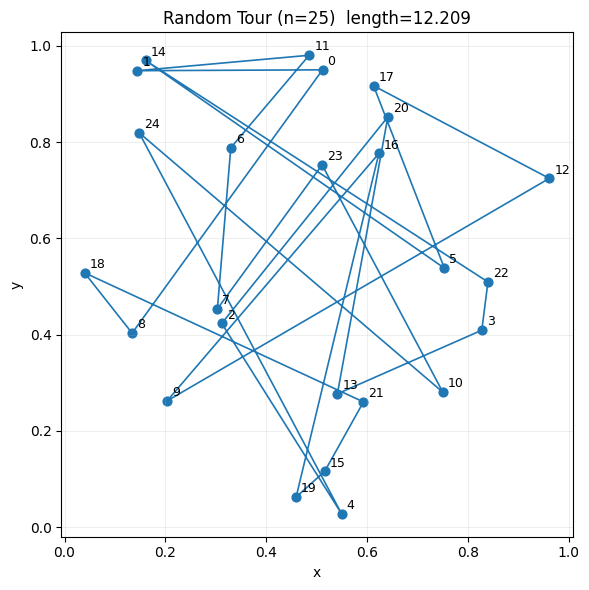

step=100000  現在=3.940  最良=3.854
step=150000  現在=3.960  最良=3.854
step=200000  現在=3.967  最良=3.854


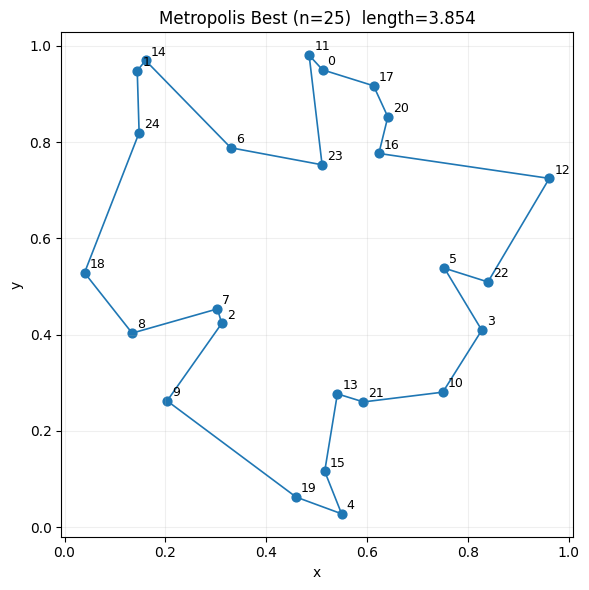

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# NumPyだけ：TSP + Metropolis(2-opt) + プロット（完全版・1ファイル）
#  - 初期のランダム巡回を描く
#  - Metropolisで改善した最良巡回を描く
# ============================================================

def dist_matrix(xy: np.ndarray) -> np.ndarray:
    d = xy[:, None, :] - xy[None, :, :]
    return np.sqrt((d * d).sum(axis=2))

def tour_length(perm: np.ndarray, D: np.ndarray) -> float:
    nxt = np.roll(perm, -1)
    return float(D[perm, nxt].sum())

def delta_len_2opt(perm: np.ndarray, i: int, k: int, D: np.ndarray) -> float:
    """
    2-opt: perm[i:k+1] を反転する場合の距離差 ΔL を O(1) で返す
    """
    n = perm.size
    a = perm[i - 1]
    b = perm[i]
    c = perm[k]
    d = perm[(k + 1) % n]

    # 旧: (a-b) + (c-d)
    # 新: (a-c) + (b-d)
    return (D[a, c] + D[b, d]) - (D[a, b] + D[c, d])

def metropolis_tsp(
    xy: np.ndarray,
    steps: int = 200_000,
    T: float = 0.02,
    seed: int = 0,
    report_every: int = 50_000,
):
    rng = np.random.default_rng(seed)
    D = dist_matrix(xy)
    n = xy.shape[0]

    # 初期：ランダム巡回
    perm = rng.permutation(n)
    curL = tour_length(perm, D)

    best_perm = perm.copy()
    bestL = curL

    for t in range(1, steps + 1):
        i, k = rng.integers(0, n, size=2)
        if i == k:
            continue
        if i > k:
            i, k = k, i

        # つまらないケースを少し避ける（なくても動く）
        if (i == 0 and k == n - 1) or (k == i + 1):
            continue

        dL = delta_len_2opt(perm, i, k, D)

        # 受理判定
        if dL <= 0.0 or rng.random() < np.exp(-dL / T):
            perm[i:k+1] = perm[i:k+1][::-1]
            curL += dL

            if curL < bestL:
                bestL = curL
                best_perm = perm.copy()

        if report_every and (t % report_every == 0):
            print(f"step={t}  現在={curL:.3f}  最良={bestL:.3f}")

    return best_perm, bestL

def plot_tour(xy: np.ndarray, perm: np.ndarray, title: str, show_labels: bool = True):
    tour = np.r_[perm, perm[0]]

    plt.figure(figsize=(6, 6))
    plt.scatter(xy[:, 0], xy[:, 1], s=40)

    if show_labels:
        for i, (x, y) in enumerate(xy):
            plt.text(x + 0.01, y + 0.01, str(i), fontsize=9)

    plt.plot(xy[tour, 0], xy[tour, 1], linewidth=1.2)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

def main():
    # 都市生成（再現性あり）
    n_cities = 25
    city_seed = 1
    rng = np.random.default_rng(city_seed)
    xy = rng.random((n_cities, 2))

    # 初期巡回（ランダム）
    init_seed = 123
    init_perm = np.random.default_rng(init_seed).permutation(n_cities)

    # 初期ルートを描く
    D = dist_matrix(xy)
    init_len = tour_length(init_perm, D)
    plot_tour(xy, init_perm, f"Random Tour (n={n_cities})  length={init_len:.3f}", show_labels=True)

    # Metropolisで改善
    best_perm, best_len = metropolis_tsp(
        xy,
        steps=200_000,
        T=0.02,        # 小さめ：改善寄り（局所探索に近い）
        seed=0,
        report_every=50_000
    )

    # 最良ルートを描く
    plot_tour(xy, best_perm, f"Metropolis Best (n={n_cities})  length={best_len:.3f}", show_labels=True)

if __name__ == "__main__":
    main()
